## **Tarea PLN**

En este proyecto se aborda la clasificación multietiqueta de textos provenientes de redes sociales, específicamente tweets.

Se trata de un problema de clasificación multietiqueta en el que tenéis que etiquetar un conjunto de tweets de acuerdo a 11 sentimientos ('anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust').

Disponemos de un conjunto de 3561 tweets etiquetas para entrenar y validar el modelo o modelos necesarios, en el archivo 'sem_eval_train_es.csv'.

### Importación de datos

In [ ]:
import pandas as pd

In [ ]:
# Cargar el conjunto de datos de entrenamiento
df = pd.read_csv('/kaggle/input/trainn/sem_eval_train_es (1).csv')

### EDA - Análisis Exploratorio de Datos

In [ ]:
# Describir el dataframe para entender la estructura de los datos
df.describe(include='all')

**Estadísticas Descriptivas**

Las estadísticas descriptivas proporcionan una visión general de los datos:

- **ID**: Cada tweet tiene un ID único.

- **Tweet**: Todos los tweets son únicos.


- **Etiquetas**: Cada sentimiento (anger, anticipation, etc.) tiene valores booleanos (True/False), indicando la presencia o ausencia del sentimiento en cada tweet.

<Axes: title={'center': 'Distribución de las etiquetas'}>

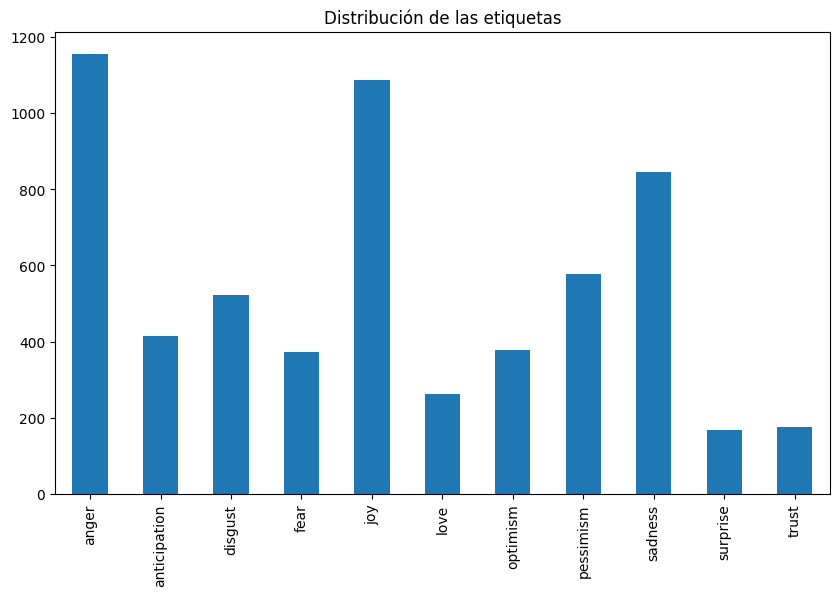

In [5]:
# Contar la frecuencia de cada sentimiento
label_counts = df.iloc[:, 2:].sum()
label_counts.plot(kind='bar', figsize=(10, 6), title="Distribución de las etiquetas")

** Distribución de las etiquetas**

El gráfico de barras muestra la frecuencia de cada sentimiento en el conjunto de datos:


- **Más frecuentes**: joy, love, optimism, surprise, trust.
- **Menos frecuentes**: anticipation, fear, sadness, pessimism, disgust, anger.

<Axes: title={'center': 'Distribución de la longitud de los tweets'}, ylabel='Frequency'>

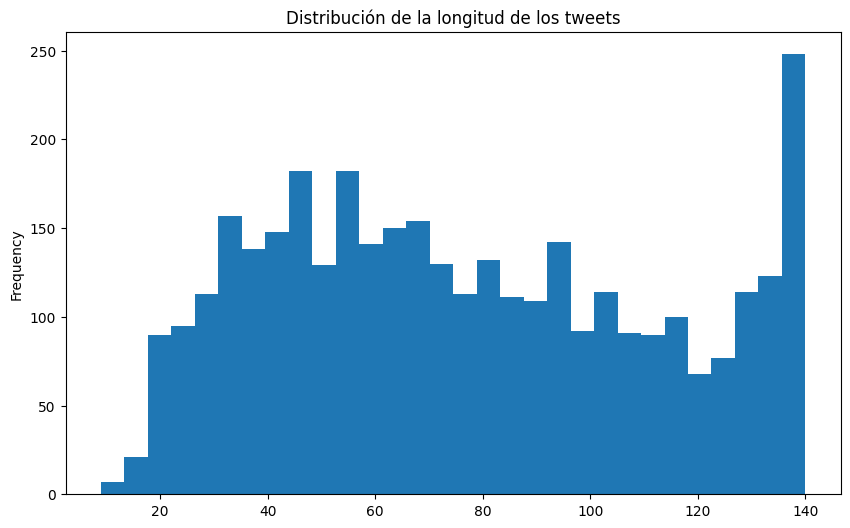

In [ ]:
# Calcular la longitud de cada tweet
df['Tweet_length'] = df['Tweet'].apply(len)

# Describir la longitud de los tweets
df['Tweet_length'].describe()

# Visualizar la distribución de la longitud de los tweets
df['Tweet_length'].plot(kind='hist', bins=30, figsize=(10, 6), title="Distribución de la longitud de los tweets")

**Longitud de los tweets**

El análisis de la longitud de los tweets muestra:

- Promedio: La longitud promedio de los tweets.
- Distribución: La mayoría de los tweets tienen entre 50 y 150 caracteres.

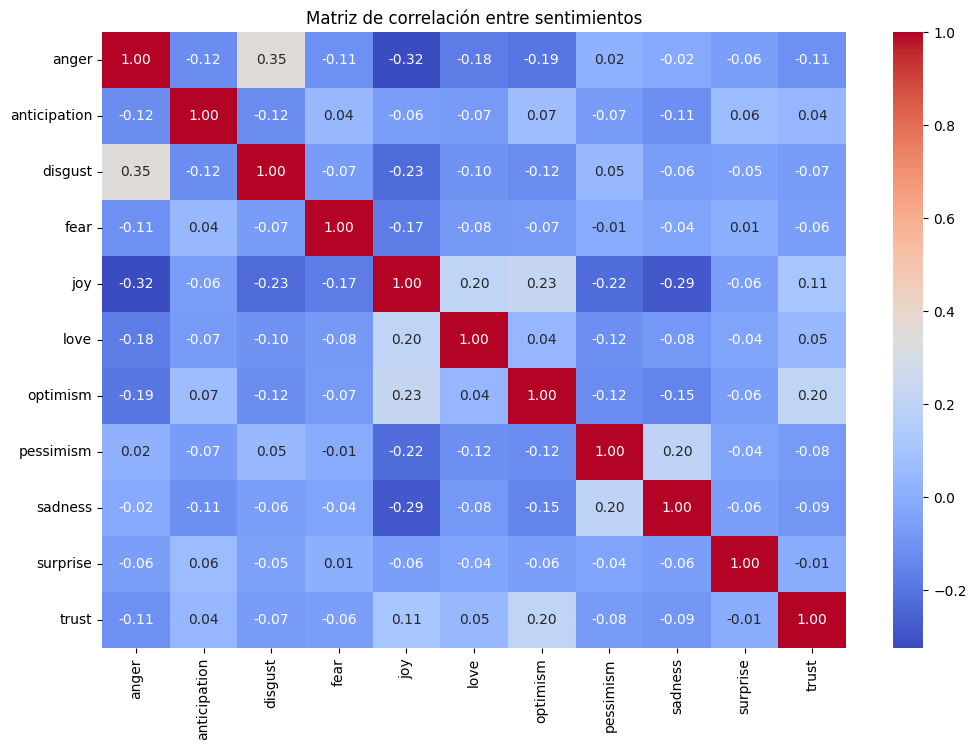

In [ ]:
# Calcular la correlación entre las etiquetas
correlation_matrix = df.iloc[:, 2:-1].corr()

# Visualizar la matriz de correlación
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlación entre sentimientos")
plt.show()


La matriz de correlación muestra relaciones interesantes entre los sentimientos. Por ejemplo, sentimientos como joy y love pueden estar correlacionados positivamente, mientras que fear y trust pueden tener correlaciones negativas.

### Preprocesamiento de los datos

**Limpieza del texto**

Empezamos con la limpieza de los tweets por medio de la función limpiar_texto que realiza varias operaciones de limpieza sobre un texto de entrada (en este caso, un tweet):

- Convertir a minúsculas: Transforma todo el texto a minúsculas para uniformar las palabras.
- Eliminar menciones: Quita las menciones a otros usuarios de Twitter, que comienzan con el símbolo @.
- Eliminar hashtags: Elimina los hashtags que comienzan con el símbolo #.
- Eliminar URLs: Quita las direcciones web que empiezan con http.
- Eliminar caracteres especiales: Remueve todos los caracteres no alfanuméricos, dejando solo letras y números.
- Eliminar espacios extra: Sustituye múltiples espacios por uno solo.
- Eliminar espacios al principio y al final: Elimina los espacios adicionales al principio y al final del texto.

In [6]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def limpiar_texto(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'@\w+', '', text)  # Eliminar menciones
    text = re.sub(r'#\w+', '', text)  # Eliminar hashtags
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'\W', ' ', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text)  # Eliminar espacios extra
    text = text.strip()  # Eliminar espacios al principio y al final
    return text

df['Tweet'] = df['Tweet'].apply(limpiar_texto)

# Mostrar algunos ejemplos de tweets limpiados
df[['Tweet']].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tweet
0,ajajjaa somos del clan twitteras perdidas pa e...
1,la mala suerte del gato fichame la cara de hel...
2,a mí tampoco me agrado mucho eso especialmente...
3,para llevar a los bebes de un lugar a otro deb...
4,me encanta la terrible hipocresia y doble mora...


**Tokenización y eliminación de stopwords**

Vamos a tokenizar los tweets y eliminar las palabras vacías por medio de la función eliminar_stopwords que realiza las siguientes operaciones:

- Tokenización: Divide el texto en palabras individuales (tokens).
- Filtrado de stopwords: Elimina las palabras que están en el conjunto de stopwords previamente descargado.
- Reconstrucción del texto: Une los tokens filtrados de nuevo en una cadena de texto.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def eliminar_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Tweet'] = df['Tweet'].apply(eliminar_stopwords)

# Mostrar algunos ejemplos de tweets después de eliminar stopwords
df[['Tweet']].head()

,Tweet
0,ajajjaa clan twitteras perdidas pa eventos imp...
1,mala suerte gato fichame cara help pls
2,tampoco agrado especialmente tratarse justific...
3,llevar bebes lugar debemos cantarles canciones...
4,encanta terrible hipocresia doble moral gente ...


Para transformar los textos en una representación numérica adecuada para el modelo de clasificación, utilizamos la técnica TF-IDF (Term Frequency-Inverse Document Frequency). 

En este caso, limitamos el número de características (palabras) a 1000 para reducir la dimensionalidad y mejorar la eficiencia computacional.

In [8]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Tweet'])

# Mostrar la forma de la matriz resultante
X.shape

(3561, 1000)

### Partición de los datos

Después de preprocesar los tweets y convertirlos a una representación numérica utilizando TF-IDF, el siguiente paso es dividir los datos en conjuntos de entrenamiento y prueba. Esto es crucial para evaluar el rendimiento del modelo de clasificación multietiqueta. Utilizaremos la función train_test_split de scikit-learn para esta tarea.

In [9]:
from sklearn.model_selection import train_test_split

# Separar características y etiquetas
X = vectorizer.transform(df['Tweet'])
y = df.iloc[:, 2:]  # Seleccionar todas las columnas de etiquetas

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2848, 1000), (713, 1000), (2848, 11), (713, 11))

### Construcción y entrenamiento de regresión logística

En esta fase del proyecto entramos en el primer proceso de construcción y entrenamiento de un modelo. 

En este caso, utilizamos un modelo de regresión logística para entrenar y evaluar la capacidad del modelo para predecir múltiples etiquetas para cada tweet. La evaluación del modelo incluye métricas como precisión, recall, f1-score y exactitud.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score

# Crear y entrenar el modelo
logreg = LogisticRegression(max_iter=1000)
model = MultiOutputClassifier(logreg)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)

# Asegurarse de que las etiquetas sean booleanas
y_test_bool = y_test.astype(bool)
y_pred_bool = y_pred.astype(bool)

# Evaluar el modelo
classification_report_result = classification_report(y_test_bool, y_pred_bool, target_names=y.columns)
accuracy = accuracy_score(y_test_bool, y_pred_bool)

print(classification_report_result)
print("Exactitud: ", accuracy)


              precision    recall  f1-score   support

       anger       0.74      0.32      0.45       222
anticipation       0.00      0.00      0.00        88
     disgust       1.00      0.03      0.06        91
        fear       1.00      0.12      0.22        66
         joy       0.92      0.31      0.47       215
        love       0.75      0.06      0.12        47
    optimism       0.00      0.00      0.00        83
   pessimism       0.50      0.01      0.02       122
     sadness       0.82      0.20      0.32       157
    surprise       1.00      0.03      0.05        40
       trust       1.00      0.03      0.05        37

   micro avg       0.82      0.16      0.27      1168
   macro avg       0.70      0.10      0.16      1168
weighted avg       0.70      0.16      0.24      1168
 samples avg       0.25      0.19      0.21      1168

Exactitud:  0.18513323983169705


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


A continuación se presentan los puntos clave del rendimiento del modelo:

- Precisión: Algunas etiquetas como "anger", "joy", y "sadness" muestran una precisión moderada, mientras que etiquetas como "anticipation" y "optimism" tienen una precisión muy baja.
- Recall: La mayoría de las etiquetas tienen un recall bajo, indicando que el modelo no identifica correctamente muchas instancias positivas. Varias etiquetas tienen un recall de 0.
- F1-Score: El F1-score es bajo para la mayoría de las etiquetas, reflejando el bajo rendimiento tanto en precisión como en recall.

Exactitud Global: La exactitud del modelo es del 18.51%, lo que indica un bajo rendimiento general.


Las métricas agregadas reflejan el bajo rendimiento general del modelo en la clasificación multietiqueta.

### Construcción y entrenamiento FNN propia

En esta sección se describe el uso de una red neuronal para la clasificación multietiqueta de tweets. 

Se utilizará una red neuronal profunda con capas densas y dropout para mejorar la capacidad del modelo de generalizar y evitar el sobreajuste.

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Convertir las etiquetas booleanas a valores numéricos (0 y 1)
y_train_numeric = y_train.astype(int)
y_test_numeric = y_test.astype(int)

# Definir el modelo de red neuronal
model_nn = Sequential()
model_nn.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(64, activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(y_train_numeric.shape[1], activation='sigmoid'))

# Compilar el modelo
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history = model_nn.fit(X_train.toarray(), y_train_numeric,
                       epochs=20,
                       batch_size=32,
                       validation_split=0.2,
                       callbacks=[early_stopping])

# Evaluar el modelo
y_pred_nn = model_nn.predict(X_test.toarray())
y_pred_nn_bool = (y_pred_nn > 0.5).astype(bool)

classification_report_nn = classification_report(y_test_bool, y_pred_nn_bool, target_names=y.columns)
accuracy_nn = accuracy_score(y_test_bool, y_pred_nn_bool)

print(classification_report_nn)
print("Exactitud: ", accuracy_nn)


2024-06-15 08:35:25.844765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 08:35:25.844944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 08:35:25.930860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
64/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1403 - loss: 0.6389

I0000 00:00:1718440541.203537     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718440541.216808     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1440 - loss: 0.6297

W0000 00:00:1718440544.207098     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718440544.677510     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.1444 - loss: 0.6287 - val_accuracy: 0.2421 - val_loss: 0.4068
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2748 - loss: 0.4099 - val_accuracy: 0.3561 - val_loss: 0.3993
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3107 - loss: 0.4003 - val_accuracy: 0.4561 - val_loss: 0.3948
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3377 - loss: 0.3905 - val_accuracy: 0.4667 - val_loss: 0.3900
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3816 - loss: 0.3802 - val_accuracy: 0.4667 - val_loss: 0.3809
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4391 - loss: 0.3622 - val_accuracy: 0.4509 - val_loss: 0.3728
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4804 - loss: 0.3477 - val_accuracy: 0.4789 - val_loss: 0.3644
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5232 - loss: 0.3206 - val_accuracy: 0.4561 - val_loss: 0.3627
Ep

W0000 00:00:1718440547.876689     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

       anger       0.63      0.47      0.54       222
anticipation       0.00      0.00      0.00        88
     disgust       1.00      0.01      0.02        91
        fear       0.00      0.00      0.00        66
         joy       0.69      0.44      0.54       215
        love       0.00      0.00      0.00        47
    optimism       0.00      0.00      0.00        83
   pessimism       0.00      0.00      0.00       122
     sadness       0.76      0.24      0.37       157
    surprise       0.00      0.00      0.00        40
       trust       0.00      0.00      0.00        37

   micro avg       0.68      0.20      0.31      1168
   macro avg       0.28      0.11      0.13      1168
weighted avg       0.43      0.20      0.25      1168
 samples avg       0.32      0.23      0.26      1168

Exactitud:  0.19074333800841514


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


El modelo de red neuronal muestra un rendimiento moderado, con algunas etiquetas mostrando mejoras y otras aún teniendo un bajo rendimiento. El modelo de red neuronal muestra algunas mejoras en ciertas etiquetas en comparación con el modelo de regresión logística, especialmente en etiquetas como "anger" y "joy". Muchas etiquetas aún tienen un rendimiento bajo, especialmente aquellas con pocos ejemplos en los datos de entrenamiento.

La exactitud general es de aproximadamente 19.07%, ligeramente mejor que el modelo de regresión logística.

### Construcción y entrenamiento de Bert Español

Este código realiza varias tareas relacionadas con el procesamiento de texto y la clasificación de secuencias usando un modelo BERT preentrenado sobre un corpus en español. 

In [12]:
pip install -q transformers[torch]

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


Primero establecemos una variable de entorno para deshabilitar Weights & Biases, una plataforma de seguimiento de experimentos.
Una vez eso, nos dedicamos a copiar toda la limpieza y preprocesamiento que hemos hecho anteriormente sobre el texto.
Además, de volver a dividir los datos debido a que los hemos vuelto a cargar de nuevo. 

Cargamos el tokenizador y el modelo BERT preentrenado en español. El modelo lo configuramos para realizar la clasificación de secuencias de las clases que tenemos en el problema.


Tras esto, definimos la TweetDataset heredada de la función Dataset de PyTorch que utilizamos para preparar los datos para el modelo BERT.
Esta clase tiene métodos para inicializar el dataset, determinar su longitud y obtener elementos individuales. Cada elemento consiste en un diccionario con entradas codificadas ('input_ids'), máscaras de atención ('attention_mask') y etiquetas ('labels').

El entrenamiento del modelo implica configurar los argumentos de entrenamiento, crear un objeto Trainer y llamar al método train() para iniciar el proceso de entrenamiento. Los argumentos de entrenamiento incluyen detalles como el directorio de salida, el número de épocas, el tamaño del lote, la estrategia de acumulación de gradiente y más.
Después del entrenamiento, el modelo se evalúa en el conjunto de validación utilizando el método predict() del objeto Trainer. Las predicciones se procesan para convertirlas en probabilidades y luego en etiquetas binarias basándose en un umbral. Esto permite comparar las predicciones del modelo con las etiquetas verdaderas para calcular métricas como precisión, recall y F1-score.

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import os
os.environ["WANDB_DISABLED"] = "true"

# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Función para limpiar texto
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Función para eliminar stopwords
def eliminar_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Cargar y preprocesar los datos
df = pd.read_csv('/kaggle/input/trainn/sem_eval_train_es (1).csv')
df['Tweet'] = df['Tweet'].apply(limpiar_texto).apply(eliminar_stopwords)

# Separar las características y las etiquetas
X = df['Tweet']
y = df.iloc[:, 2:]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cargar el tokenizador y el modelo preentrenado
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=y_train.shape[1])

# Preparar los datos para BERT
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        labels = self.labels.iloc[idx].values.astype(float)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Crear datasets
train_dataset = TweetDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = TweetDataset(X_test, y_test, tokenizer, max_len=128)

# Configurar el entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,  # Reducir el tamaño del lote
    per_device_eval_batch_size=8,  # Reducir el tamaño del lote
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    gradient_accumulation_steps=2,  # Acumular gradientes para simular un tamaño de lote mayor
)

# Crear el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Liberar memoria de la GPU
torch.cuda.empty_cache()

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)

# Aplicar una función sigmoide a las predicciones para obtener probabilidades
probabilities = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()

# Convertir probabilidades a etiquetas binarias utilizando un umbral (por ejemplo, 0.5)
y_pred_bin = (probabilities >= 0.5).astype(int)

# Convertir las etiquetas verdaderas a numpy
y_true = y_test.to_numpy()

# Asegúrate de que las etiquetas sean booleanas
y_test_bool = y_true.astype(bool)
y_pred_bool = y_pred_bin.astype(bool)

# Generar el reporte de clasificación
report = classification_report(y_test_bool, y_pred_bool, target_names=y.columns)
accuracy = accuracy_score(y_test_bool, y_pred_bool)

print(report)
print("Exactitud: ", accuracy)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vecto

Epoch,Training Loss,Validation Loss
1,0.429300,0.399856
2,0.370300,0.359306
3,0.328200,0.338250
4,0.287200,0.318197
5,0.248200,0.313306
6,0.205800,0.323374
7,0.144400,0.346813
8,0.117500,0.354053
9,0.089500,0.359701
10,0.073700,0.366200


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

              precision    recall  f1-score   support

       anger       0.63      0.65      0.64       222
anticipation       0.48      0.35      0.41        88
     disgust       0.49      0.31      0.38        91
        fear       0.65      0.64      0.64        66
         joy       0.74      0.73      0.73       215
        love       0.67      0.38      0.49        47
    optimism       0.36      0.18      0.24        83
   pessimism       0.44      0.34      0.39       122
     sadness       0.61      0.56      0.58       157
    surprise       0.50      0.05      0.09        40
       trust       0.88      0.19      0.31        37

   micro avg       0.61      0.49      0.54      1168
   macro avg       0.58      0.40      0.45      1168
weighted avg       0.59      0.49      0.52      1168
 samples avg       0.55      0.51      0.50      1168

Exactitud:  0.27349228611500703


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


El modelo de clasificación de emociones basado en tweets demuestra un rendimiento mixto, con variaciones significativas en el desempeño entre diferentes categorías emocionales. Aunque la pérdida de entrenamiento disminuye a lo largo de las épocas, indicando que el modelo está aprendiendo, la pérdida de validación aumenta ligeramente después de la sexta época, lo que sugiere posibles problemas de sobreajuste o limitaciones en la capacidad del modelo para mejorar con los datos actuales.

En términos de métricas de clasificación, el modelo muestra un rendimiento decente en categorías como "joy" y "fear", con altas puntuaciones de precisión y recall. Sin embargo, enfrenta desafíos significativos en categorías como "surprise", donde el recall es extremadamente bajo, lo que indica dificultades para identificar correctamente los tweets que expresan sorpresa. Esta situación podría deberse a la rareza o sutileza de los ejemplos de "surprise" en el conjunto de datos.

Además, existe una notable variabilidad en el rendimiento entre diferentes categorías, lo que sugiere oportunidades para ajustar el modelo o el proceso de entrenamiento para mejorar el rendimiento en categorías específicas. La precisión media es moderada (0.61), mientras que el recall es bajo (0.49), lo que subraya las dificultades del modelo para identificar correctamente todos los ejemplos positivos de cada categoría.

La exactitud general del modelo es relativamente baja (0.27), lo que indica que hay margen significativo para mejorar. Este resultado bajo en exactitud sugiere que el modelo necesita trabajar tanto en aumentar su precisión como en mejorar su capacidad para detectar casos positivos.

### Bert Español v2

En búsqueda de una mejora del rendimiento del modelo se han añadido dos parámetros adicionales a TrainingArguments: learning_rate y weight_decay, que están ajustados a 3e-5 y 0.01, respectivamente. 

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import os
os.environ["WANDB_DISABLED"] = "true"

# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Función para limpiar texto
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Función para eliminar stopwords
def eliminar_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Cargar el conjunto de datos de entrenamiento
df = pd.read_csv('/kaggle/input/trainn/sem_eval_train_es (1).csv')
df['Tweet'] = df['Tweet'].apply(limpiar_texto).apply(eliminar_stopwords)

# Separar las características y las etiquetas
X = df['Tweet']
y = df.iloc[:, 2:]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cargar el tokenizador y el modelo BETO
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Preparar los datos para BERT
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        labels = self.labels.iloc[idx].values.astype(float)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Crear datasets
train_dataset = TweetDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = TweetDataset(X_test, y_test, tokenizer, max_len=128)

# Definir el modelo BETO para clasificación multietiqueta
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=y_train.shape[1])

# Configurar el entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Crear el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)

# Aplicar una función sigmoide a las predicciones para obtener probabilidades
probabilities = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()

# Convertir probabilidades a etiquetas binarias utilizando un umbral (por ejemplo, 0.5)
y_pred_bin = (probabilities >= 0.5).astype(int)

# Convertir las etiquetas verdaderas a numpy
y_true = y_test.to_numpy()

# Generar el reporte de clasificación
report = classification_report(y_true, y_pred_bin, target_names=y.columns)
accuracy = accuracy_score(y_true, y_pred_bin)

print(report)
print("Exactitud: ", accuracy)


2024-06-15 11:02:08.530173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 11:02:08.530305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 11:02:08.810037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `W

Epoch,Training Loss,Validation Loss
1,0.376400,0.386469
2,0.344800,0.340404
3,0.309700,0.318767
4,0.230500,0.323880
5,0.206200,0.322013
6,0.167000,0.332145
7,0.125200,0.344918
8,0.112000,0.355242
9,0.086900,0.362775
10,0.066500,0.364378


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

              precision    recall  f1-score   support

       anger       0.64      0.64      0.64       222
anticipation       0.48      0.36      0.41        88
     disgust       0.43      0.29      0.34        91
        fear       0.77      0.65      0.70        66
         joy       0.77      0.70      0.73       215
        love       0.63      0.40      0.49        47
    optimism       0.40      0.20      0.27        83
   pessimism       0.47      0.30      0.36       122
     sadness       0.60      0.54      0.57       157
    surprise       0.50      0.07      0.13        40
       trust       0.75      0.16      0.27        37

   micro avg       0.62      0.48      0.54      1168
   macro avg       0.59      0.39      0.45      1168
weighted avg       0.60      0.48      0.52      1168
 samples avg       0.56      0.50      0.50      1168

Exactitud:  0.28892005610098176


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Los resultados indican que el modelo ha experimentado mejoras significativas en su rendimiento, especialmente en términos de precisión y recall para varias categorías como "fear", "joy" y "trust". La disminución continua de la pérdida de entrenamiento y la mejora en la exactitud general sugieren que el modelo está aprendiendo eficazmente de los datos y adaptándose bien a la tarea de clasificación de emociones. 

Sin embargo, todavía existen oportunidades para mejorar, especialmente en categorías como "surprise", donde el recall sigue siendo bajo.

La exactitud general aumenta a 0.29, lo que refleja una mejora en la capacidad del modelo para clasificar correctamente todas las categorías. 

### Bert Español v3

Para esta tercera versión del clasificador basado en el modelo Bert en español hemos implementado diferentes mejoras como: 
- Hemos añadido esta línea r'[^a-záéíóúñü ]' para eliminar caracteres no deseados en búsqueda de una limpieza de texto más efectiva.
- Introducción de la optimización de umbrales utilizando la métrica F1


In [1]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score 
from sklearn.model_selection import GridSearchCV
import os
os.environ["WANDB_DISABLED"] = "true"

# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Función para limpiar texto
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'[^a-záéíóúñü ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Función para eliminar stopwords
def eliminar_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Cargar el conjunto de datos de entrenamiento
df = pd.read_csv('/kaggle/input/trainn/sem_eval_train_es (1).csv')
df['Tweet'] = df['Tweet'].apply(limpiar_texto).apply(eliminar_stopwords)

# Separar las características y las etiquetas
X = df['Tweet']
y = df.iloc[:, 2:]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cargar el tokenizador y el modelo BETO
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Preparar los datos para BERT
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        labels = self.labels.iloc[idx].values.astype(float)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Crear datasets
train_dataset = BERTDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = BERTDataset(X_test, y_test, tokenizer, max_len=128)

# Definir el modelo BETO para clasificación multietiqueta
model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=y_train.shape[1])

# Configurar el entrenamiento con búsqueda de hiperparámetros
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10, 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Crear el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)

# Aplicar una función sigmoide a las predicciones para obtener probabilidades
probabilities = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()

# Optimizar los umbrales para cada etiqueta
optimal_thresholds = []
for i in range(y_train.shape[1]):
    best_threshold = 0.5
    best_f1 = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred_bin = (probabilities[:, i] >= threshold).astype(int)
        f1 = f1_score(y_test.iloc[:, i], y_pred_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    optimal_thresholds.append(best_threshold)

# Convertir probabilidades a etiquetas binarias utilizando los umbrales óptimos
y_pred_bin = np.zeros(probabilities.shape)
for i in range(probabilities.shape[1]):
    y_pred_bin[:, i] = (probabilities[:, i] >= optimal_thresholds[i]).astype(int)

# Convertir las etiquetas verdaderas a numpy
y_true = y_test.to_numpy()

# Generar el reporte de clasificación
report = classification_report(y_true, y_pred_bin, target_names=y.columns)
accuracy = accuracy_score(y_true, y_pred_bin)

print(report)
print("Exactitud: ", accuracy)


2024-06-18 17:34:35.047299: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 17:34:35.047401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 17:34:35.216196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `W

Epoch,Training Loss,Validation Loss
1,0.376300,0.388016
2,0.346000,0.341751
3,0.305300,0.316330
4,0.237100,0.319855
5,0.201600,0.320835
6,0.160800,0.332798
7,0.121600,0.342612
8,0.114900,0.353981
9,0.081400,0.360693
10,0.067800,0.362656


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

              precision    recall  f1-score   support

       anger       0.62      0.71      0.66       222
anticipation       0.31      0.52      0.39        88
     disgust       0.40      0.44      0.42        91
        fear       0.69      0.70      0.69        66
         joy       0.84      0.64      0.73       215
        love       0.57      0.53      0.55        47
    optimism       0.32      0.40      0.36        83
   pessimism       0.41      0.49      0.45       122
     sadness       0.53      0.61      0.56       157
    surprise       0.32      0.20      0.25        40
       trust       0.52      0.30      0.38        37

   micro avg       0.53      0.57      0.55      1168
   macro avg       0.50      0.50      0.49      1168
weighted avg       0.55      0.57      0.55      1168
 samples avg       0.53      0.57      0.52      1168

Exactitud:  0.2244039270687237


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


La precisión media aumenta a 0.53, mientras que el recall aumenta a 0.57. Esto indica que el modelo ha mejorado en su capacidad para clasificar correctamente las instancias positivas.
A pesar de las mejoras en la precisión y el recall para varias categorías, la disminución de la exactitud general sugiere que el modelo ha experimentado un balance adverso en su rendimiento. Mientras que el modelo ha demostrado una mejora en la capacidad para clasificar correctamente las instancias positivas y para identificar una proporción mayor de casos positivos, la disminución en la exactitud general indica que el modelo podría estar haciendo más falsos positivos o falsos negativos.

### Bert Español v4

En esta cuarta versión de Bert en español se presenta una mejora significativa en la definición del modelo mediante la introducción de una capa adicional en la clasificación, lo cual puede potencialmente mejorar el rendimiento del modelo. También incluye ajustes menores como la reducción del número de épocas y la limpieza de importaciones innecesarias

In [2]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords, wordnet
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score 
import os
os.environ["WANDB_DISABLED"] = "true"

# Descargar stopwords y wordnet
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('spanish'))

# Función para limpiar texto
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'[^a-záéíóúñü ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Función para eliminar stopwords
def eliminar_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)


# Cargar el conjunto de datos de entrenamiento
df = pd.read_csv('/kaggle/input/trainn/sem_eval_train_es (1).csv')
df['Tweet'] = df['Tweet'].apply(limpiar_texto).apply(eliminar_stopwords)


# Separar las características y las etiquetas
X = df['Tweet']
y = df.iloc[:, 2:]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cargar el tokenizador y el modelo BETO
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Preparar los datos para BERT
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        labels = self.labels.iloc[idx].values.astype(float)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Crear datasets
train_dataset = BERTDataset(X_train, y_train, tokenizer, max_len=128)
test_dataset = BERTDataset(X_test, y_test, tokenizer, max_len=128)

# Definir el modelo BETO para clasificación multietiqueta
class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(config.hidden_size, config.hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(config.hidden_size, config.num_labels)
        )

model = CustomBertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=y_train.shape[1])

# Configurar el entrenamiento con búsqueda de hiperparámetros
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8, 
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Crear el entrenador
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Entrenar el modelo
trainer.train()

# Evaluar el modelo
predictions = trainer.predict(test_dataset)

# Aplicar una función sigmoide a las predicciones para obtener probabilidades
probabilities = torch.sigmoid(torch.tensor(predictions.predictions)).numpy()

# Optimizar los umbrales para cada etiqueta
optimal_thresholds = []
for i in range(y_train.shape[1]):
    best_threshold = 0.5
    best_f1 = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred_bin = (probabilities[:, i] >= threshold).astype(int)
        f1 = f1_score(y_test.iloc[:, i], y_pred_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    optimal_thresholds.append(best_threshold)

# Convertir probabilidades a etiquetas binarias utilizando los umbrales óptimos
y_pred_bin = np.zeros(probabilities.shape)
for i in range(probabilities.shape[1]):
    y_pred_bin[:, i] = (probabilities[:, i] >= optimal_thresholds[i]).astype(int)

# Convertir las etiquetas verdaderas a numpy
y_true = y_test.to_numpy()

# Generar el reporte de clasificación
report = classification_report(y_true, y_pred_bin, target_names=y.columns)
accuracy = accuracy_score(y_true, y_pred_bin)

print(report)
print("Exactitud: ", accuracy)


2024-06-27 13:04:22.976945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 13:04:22.977074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 13:04:23.219347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.0.bias', 'classifier.0.weight', 'classifier.2.bias', 'classifier.2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use

Epoch,Training Loss,Validation Loss
1,0.396800,0.398689
2,0.387500,0.386971
3,0.353900,0.341923
4,0.293500,0.325581
5,0.252600,0.316280
6,0.218800,0.323345
7,0.175400,0.328316
8,0.188300,0.328847


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

              precision    recall  f1-score   support

       anger       0.64      0.71      0.67       222
anticipation       0.29      0.58      0.38        88
     disgust       0.40      0.42      0.41        91
        fear       0.72      0.64      0.68        66
         joy       0.70      0.73      0.72       215
        love       0.53      0.53      0.53        47
    optimism       0.44      0.33      0.37        83
   pessimism       0.34      0.59      0.43       122
     sadness       0.53      0.65      0.58       157
    surprise       0.15      0.20      0.17        40
       trust       0.30      0.32      0.31        37

   micro avg       0.49      0.59      0.54      1168
   macro avg       0.46      0.52      0.48      1168
weighted avg       0.52      0.59      0.55      1168
 samples avg       0.51      0.59      0.51      1168

Exactitud:  0.2131837307152875


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


La principal mejora en este modelo es la inclusión de una capa adicional en la clasificación, lo cual podría estar contribuyendo a un mejor recall en varias categorías.
A pesar de la reducción en la precisión y la exactitud, el aumento en el recall puede ser beneficioso en aplicaciones donde es crucial identificar tantos ejemplos como sea posible.
La diferencia en las épocas de entrenamiento no parece haber afectado significativamente los resultados generales.
Si se valora más la precisión y la exactitud, el modelo anterio podría ser más adecuado. Si el recall es más crítico, entonces este modelo puede ser preferible.





### Ensemble Learning

In [1]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score
import os

os.environ["WANDB_DISABLED"] = "true"

# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

# Función para limpiar texto
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r'(@\w+|#\w+|http\S+)', '', text)
    text = re.sub(r'[^a-záéíóúñü\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Función para eliminar stopwords
def eliminar_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Cargar el conjunto de datos de entrenamiento
df = pd.read_csv('/kaggle/input/trainn/sem_eval_train_es (1).csv')
df['Tweet'] = df['Tweet'].apply(limpiar_texto).apply(eliminar_stopwords)

# Separar las características y las etiquetas
X = df['Tweet']
y = df.iloc[:, 2:]

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cargar los tokenizadores y modelos
bert_tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Preparar los datos para los dos modelos
class BERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        labels = self.labels.iloc[idx].values.astype(float)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Crear datasets para BERT
train_dataset_bert = BERTDataset(X_train, y_train, bert_tokenizer, max_len=128)
test_dataset_bert = BERTDataset(X_test, y_test, bert_tokenizer, max_len=128)

# Crear datasets para XLM-Roberta
train_dataset_xlm = BERTDataset(X_train, y_train, xlm_tokenizer, max_len=128)
test_dataset_xlm = BERTDataset(X_test, y_test, xlm_tokenizer, max_len=128)

# Definir los modelos para clasificación multietiqueta
model_bert = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=y_train.shape[1])
model_xlm = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=y_train.shape[1])

# Configurar el entrenamiento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=3e-5,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",  # Guardar solo al final de cada epoch
    save_steps=5000,  # Guardar con menos frecuencia
    save_total_limit=1,  # Mantener solo el último checkpoint
)

# Entrenar el modelo BERT
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
)
trainer_bert.train()

# Evaluar el modelo BERT
predictions_bert = trainer_bert.predict(test_dataset_bert)
probabilities_bert = torch.sigmoid(torch.tensor(predictions_bert.predictions)).numpy()

# Liberar memoria de BERT
del model_bert
torch.cuda.empty_cache()

# Configurar el entrenamiento para XLM-Roberta
training_args.save_strategy = "no"  # No guardar checkpoints intermedios

# Entrenar el modelo XLM-Roberta
trainer_xlm = Trainer(
    model=model_xlm,
    args=training_args,
    train_dataset=train_dataset_xlm,
    eval_dataset=test_dataset_xlm,
)
trainer_xlm.train()

# Evaluar el modelo XLM-Roberta
predictions_xlm = trainer_xlm.predict(test_dataset_xlm)
probabilities_xlm = torch.sigmoid(torch.tensor(predictions_xlm.predictions)).numpy()

# Promediar las probabilidades de los dos modelos para el ensemble
probabilities_ensemble = (probabilities_bert + probabilities_xlm) / 2

# Optimizar los umbrales para cada etiqueta
optimal_thresholds = []
for i in range(y_train.shape[1]):
    best_threshold = 0.5
    best_f1 = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred_bin = (probabilities_ensemble[:, i] >= threshold).astype(int)
        f1 = f1_score(y_test.iloc[:, i], y_pred_bin)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    optimal_thresholds.append(best_threshold)

# Convertir probabilidades a etiquetas binarias utilizando los umbrales óptimos
y_pred_bin = np.zeros(probabilities_ensemble.shape)
for i in range(probabilities_ensemble.shape[1]):
    y_pred_bin[:, i] = (probabilities_ensemble[:, i] >= optimal_thresholds[i]).astype(int)

# Convertir las etiquetas verdaderas a numpy
y_true = y_test.to_numpy()

# Generar el reporte de clasificación
report = classification_report(y_true, y_pred_bin, target_names=y.columns)
accuracy = accuracy_score(y_true, y_pred_bin)

print(report)
print("Exactitud: ", accuracy)



2024-06-28 10:03:19.003535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 10:03:19.003639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 10:03:19.118799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector

Epoch,Training Loss,Validation Loss
1,0.375300,0.386784
2,0.349200,0.345280
3,0.311300,0.315067
4,0.236500,0.314358
5,0.199500,0.320661
6,0.172800,0.323587
7,0.128900,0.334665
8,0.134600,0.336417


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Epoch,Training Loss,Validation Loss
1,0.386500,0.392641
2,0.391100,0.391905
3,0.377800,0.368095
4,0.339900,0.344936
5,0.329700,0.329146
6,0.305400,0.328323
7,0.268200,0.329944
8,0.309900,0.328145


              precision    recall  f1-score   support

       anger       0.69      0.69      0.69       222
anticipation       0.38      0.41      0.39        88
     disgust       0.47      0.40      0.43        91
        fear       0.67      0.76      0.71        66
         joy       0.78      0.73      0.75       215
        love       0.54      0.53      0.54        47
    optimism       0.31      0.58      0.41        83
   pessimism       0.36      0.66      0.47       122
     sadness       0.59      0.63      0.61       157
    surprise       0.21      0.25      0.23        40
       trust       0.60      0.24      0.35        37

   micro avg       0.53      0.60      0.56      1168
   macro avg       0.51      0.53      0.51      1168
weighted avg       0.57      0.60      0.57      1168
 samples avg       0.52      0.60      0.52      1168

Exactitud:  0.21037868162692847


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusión y elección del modelo final

#### Resumen general métricas

1. Regresión Logística

- Micro F1-score: 0.27
- Macro F1-score: 0.16
- Exactitud: 0.18
La regresión logística tiene un desempeño significativamente peor al igual que el modelo ANN, lo que indica que no son adecuadas para esta tarea específica.

2. Bert Español v1
- Micro F1-score: 0.54
- Macro F1-score: 0.45
- Exactitud: 0.27
Este modelo tiene una precisión razonable y un buen equilibrio entre precisión y recall. La exactitud es baja, lo cual indica que podría estar teniendo problemas para clasificar correctamente varias etiquetas a la vez.

3. Bert Español v2
- Micro F1-score: 0.54
- Macro F1-score: 0.45
- Exactitud: 0.29
Tiene resultados similares al Bert v1, pero con una ligera mejora en la exactitud. Esto sugiere que podría ser un poco mejor en general.

4. Bert Español v3
- Micro F1-score: 0.55
- Macro F1-score: 0.49
- Exactitud: 0.22
Este modelo muestra una mejora en el macro F1-score y micro F1-score, lo que sugiere un mejor equilibrio entre las distintas clases. Sin embargo, la exactitud es más baja, lo que indica que puede estar clasificando más etiquetas incorrectamente en conjunto.

5. Bert Español v4
- Micro F1-score: 0.54
- Macro F1-score: 0.48
- Exactitud: 0.21
Presenta resultados similares al v3, con un buen balance entre las métricas de F1, pero con una baja exactitud.

6. Ensemble Learning
- Micro F1-score: 0.56
- Macro F1-score: 0.51
- Exactitud: 0.21
El modelo de ensemble muestra una ligera mejora en el micro F1-score y macro F1-score comparado con los modelos individuales. Sin embargo, la exactitud sigue siendo baja.



El micro F1-score y macro F1-score son cruciales en la clasificación multietiqueta, ya que combinan precisión y recall, proporcionando una visión más equilibrada del rendimiento del modelo. Aunque la exactitud es importante, en problemas multietiqueta puede ser engañosa, ya que una alta exactitud no siempre refleja un buen desempeño en la clasificación de todas las etiquetas.

De acuerdo a las métricas presentadas, el mejor modelo parece ser el Ensemble Learning, dado que tiene el mejor micro F1-score (0.56) y macro F1-score (0.51). Aunque la exactitud no es la mejor (0.21), las métricas de F1-score son más indicativas de un buen rendimiento en problemas de clasificación multietiqueta, donde es crucial balancear entre precisión y recall.